In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,make_scorer, f1_score
from sklearn.pipeline import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

torch.manual_seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)


<h1>Data Importing and Analysis</h1>

In [2]:
df = pd.read_csv("./diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
print(f"the data's shape is : {df.shape}")

the data's shape is : (100000, 9)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
print(f"number of duplicated rows : {df.duplicated().sum()}")

number of duplicated rows : 3854


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
for col in df.columns:
  print(f" number of unique values in {col} are {df[col].nunique()}")

 number of unique values in gender are 3
 number of unique values in age are 102
 number of unique values in hypertension are 2
 number of unique values in heart_disease are 2
 number of unique values in smoking_history are 6
 number of unique values in bmi are 4247
 number of unique values in HbA1c_level are 18
 number of unique values in blood_glucose_level are 18
 number of unique values in diabetes are 2


In [8]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [9]:
print(f"{df['gender'].value_counts()}")
df = df[df['gender'] != 'Other']

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64


In [10]:
print(df['smoking_history'].value_counts())
df['smoking_history'].replace(['never', 'No Info'],'non smoker',inplace=True)
df['smoking_history'].replace(['ever', 'former', 'not current'],'past smoker',inplace=True)

smoking_history
never          34395
No Info        32881
former          9299
current         9197
not current     6359
ever            3997
Name: count, dtype: int64


In [11]:
df['smoking_history'].value_counts()

smoking_history
non smoker     67276
past smoker    19655
current         9197
Name: count, dtype: int64

In [12]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


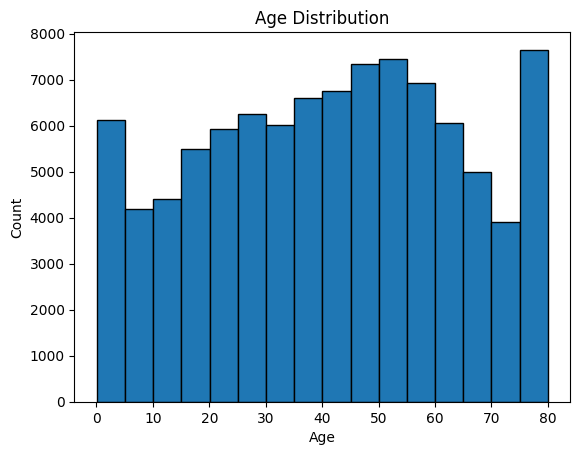

In [13]:
plt.hist(df['age'],bins=16,edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

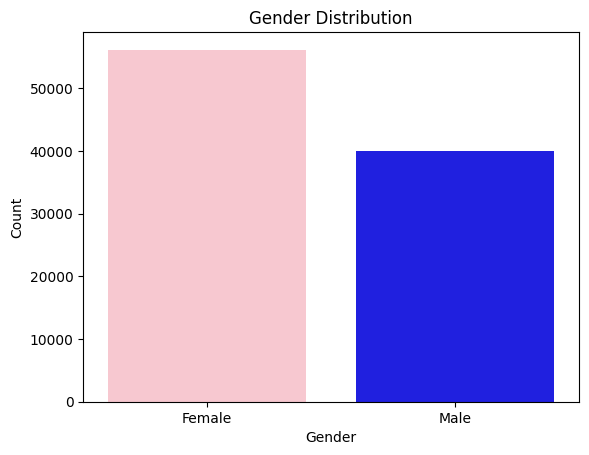

In [14]:
sns.countplot(x='gender', data=df, hue='gender', palette=['pink', 'blue'], legend=False)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

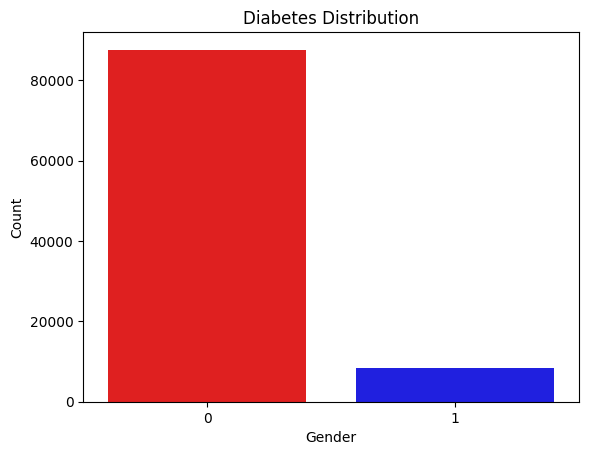

In [15]:
sns.countplot(x='diabetes', data=df, hue='diabetes', palette=['red', 'blue'], legend=False)
plt.title('Diabetes Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

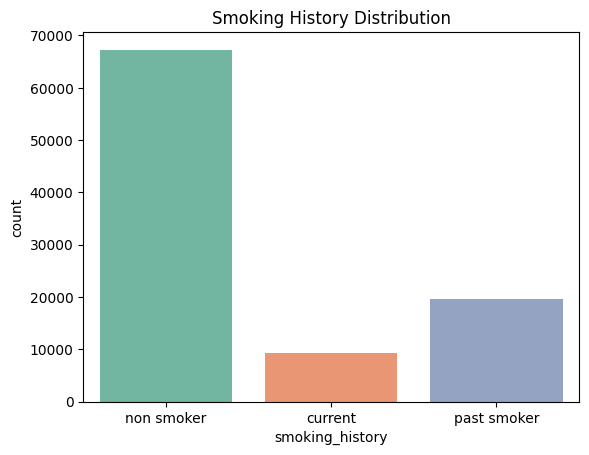

In [16]:
sns.countplot(x='smoking_history',hue='smoking_history',data=df,palette='Set2',legend=False)
plt.title('Smoking History Distribution')
plt.show()

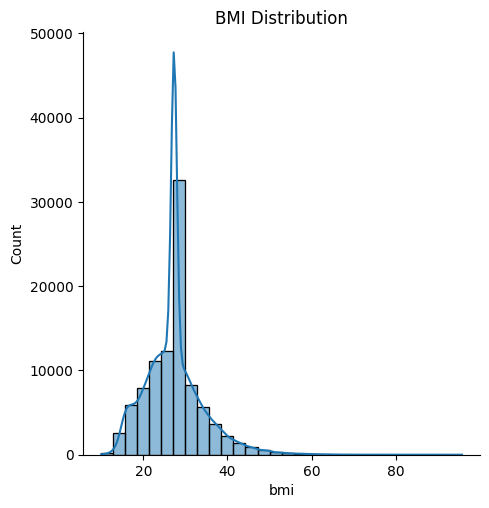

In [17]:
sns.displot(df['bmi'],bins=30,kde=True)
plt.title('BMI Distribution')
plt.show()

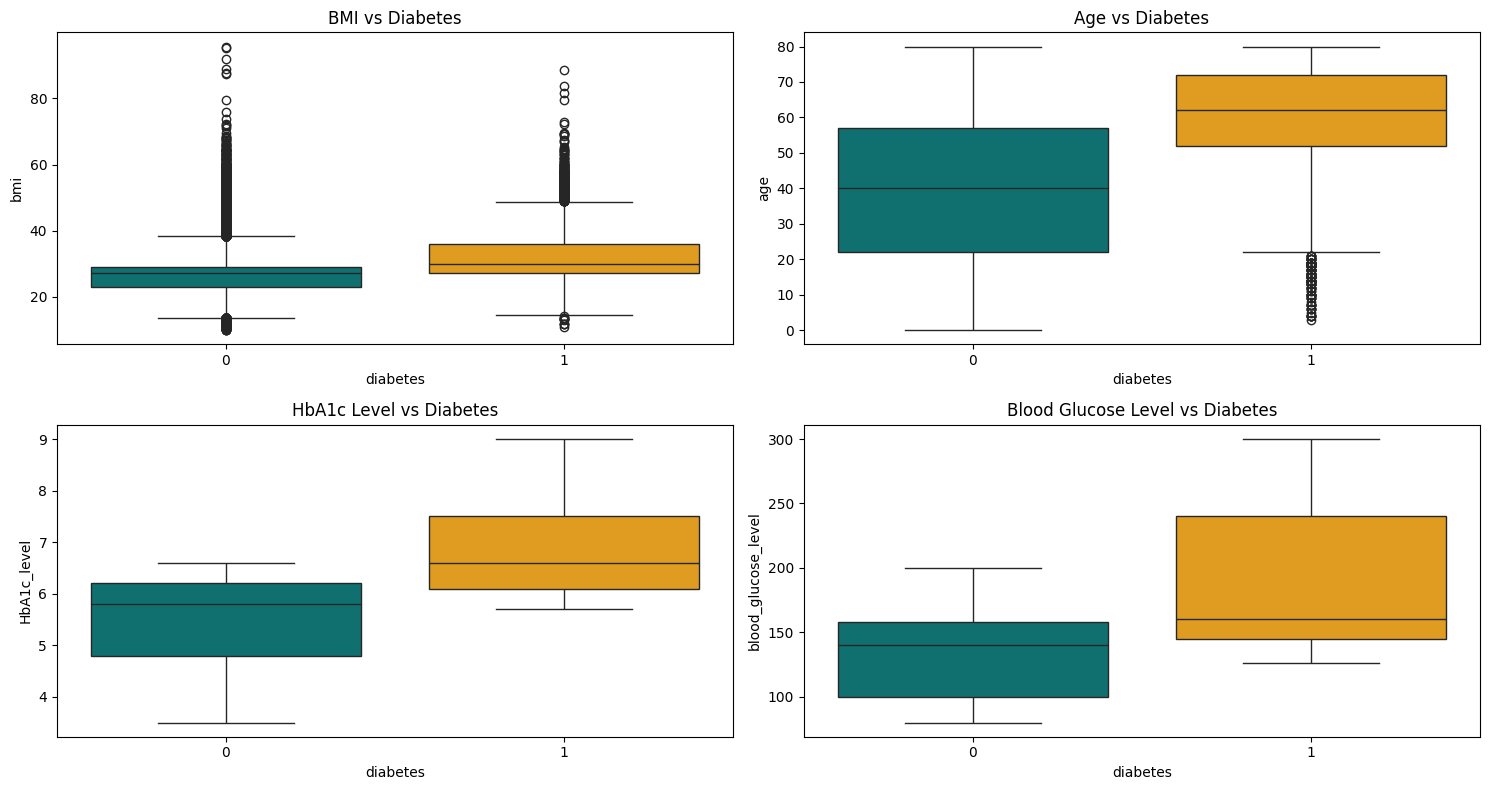

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

sns.boxplot(x='diabetes', y='bmi', data=df, hue='diabetes',legend=False, ax=axes[0, 0], palette=['teal', 'orange'])
axes[0, 0].set_title('BMI vs Diabetes')

sns.boxplot(x='diabetes', y='age', data=df, hue='diabetes',legend=False,ax=axes[0, 1], palette=['teal', 'orange'])
axes[0, 1].set_title('Age vs Diabetes')

sns.boxplot(x='diabetes', y='HbA1c_level', data=df, hue='diabetes', legend=False, ax=axes[1, 0], palette=['teal', 'orange'])
axes[1, 0].set_title('HbA1c Level vs Diabetes')

sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, hue='diabetes', legend=False, palette=['teal', 'orange'], ax=axes[1, 1])
axes[1, 1].set_title('Blood Glucose Level vs Diabetes')
plt.tight_layout()
plt.show()


In [19]:
# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

# Apply the function to remove outliers in 'bmi' and 'diabetes' columns
df_cleaned = remove_outliers_iqr(df, ['bmi','age'])

# Check the result
print("before outliers removal")
print(df[['bmi','age']].describe())
print("*"*50)
print("after outliers removal")
print(df_cleaned[['bmi', 'diabetes']].describe())


before outliers removal
                bmi           age
count  96128.000000  96128.000000
mean      27.321450     41.796617
std        6.767811     22.463329
min       10.010000      0.080000
25%       23.400000     24.000000
50%       27.320000     43.000000
75%       29.860000     59.000000
max       95.690000     80.000000
**************************************************
after outliers removal
                bmi      diabetes
count  90769.000000  90769.000000
mean      26.409602      0.079476
std        5.232696      0.270482
min       13.710000      0.000000
25%       23.170000      0.000000
50%       27.320000      0.000000
75%       28.840000      0.000000
max       39.540000      1.000000


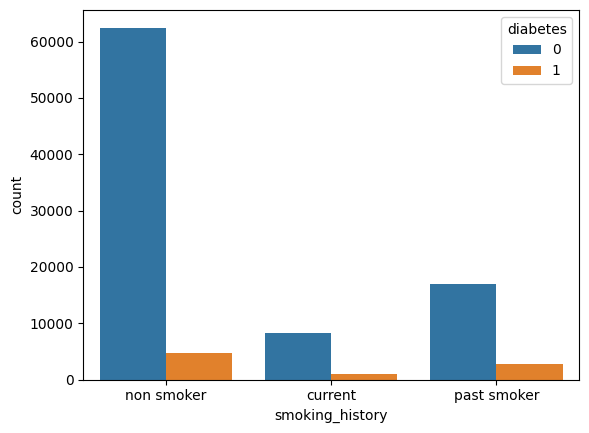

In [20]:
sns.countplot(x='smoking_history',hue='diabetes',data=df)
plt.show()

In [21]:
df_copy = df.copy()

In [22]:
df_copy = pd.get_dummies(df_copy,columns=['gender','smoking_history'],drop_first=True)
#drop_first is used since for example if gender != male ==> gender = female so the two columns will be highly correlated and will be dropped in the future

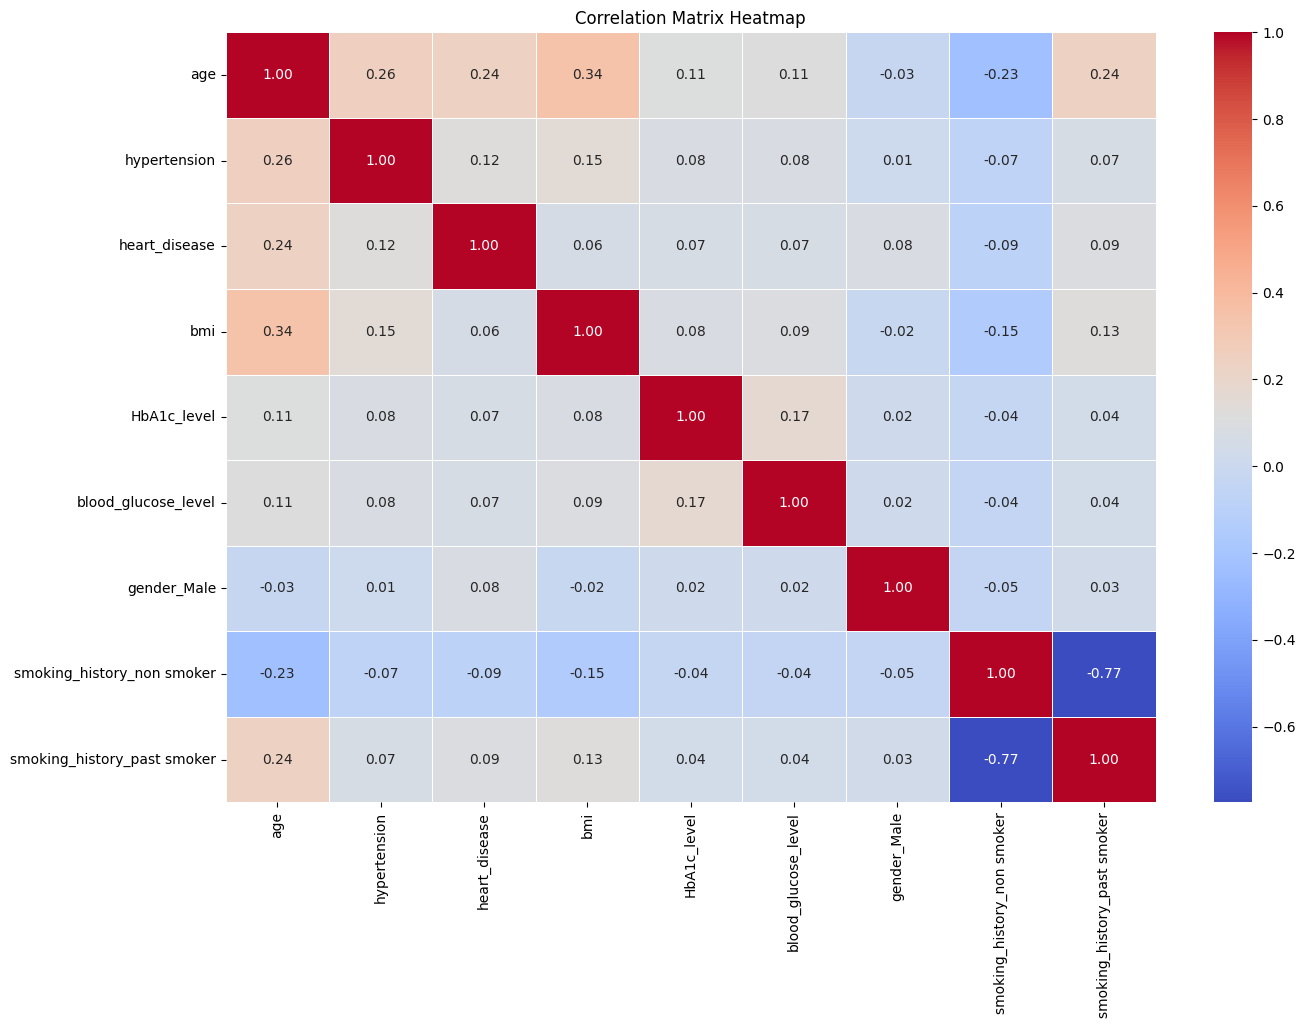

In [23]:
#correlation between every feature of the dataset
plt.figure(figsize=(15, 10))
sns.heatmap(df_copy.drop('diabetes',axis=1).corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

<Axes: >

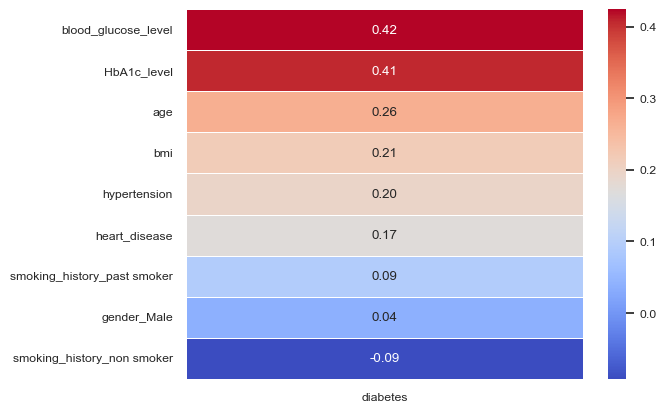

In [24]:
#correlation between each feature and the targer feature
features = df_copy.corr()['diabetes'].drop('diabetes')
features.sort_values(ascending=False,inplace=True)
sns.set_theme(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(features.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [25]:
numerical_cols = ['age','bmi','HbA1c_level','blood_glucose_level']
categorical_cols = ['gender', 'smoking_history']
remainder_cols = ['hypertension', 'heart_disease']

In [26]:
numerical_transformer = StandardScaler()
encoder = LabelEncoder()


def label_encode(df, columns):
    for col in columns:
        df[col] = encoder.fit_transform(df[col])
    return df

label_encoder = FunctionTransformer(lambda X: label_encode(X.copy(), categorical_cols), validate=False)

def create_pipeline(classifier,num_cols=numerical_cols,cat_cols=categorical_cols,lab_encoder=label_encoder,num_transformer=numerical_transformer):

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_cols),
            ("cat", lab_encoder, cat_cols),
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = ImbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("resampler", SMOTEENN(random_state=42)),
            ("classifier", classifier),
        ]
    )

    return pipeline


In [27]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h1>Random Forest</h1>

In [28]:
rf_classifier = RandomForestClassifier(n_estimators=7, random_state=42, criterion="gini", verbose=1)
random_forest_pipeline = create_pipeline(rf_classifier)

In [29]:
#fit and predict data without handling outliers


random_forest_pipeline.fit(X_train, y_train)

y_pred = random_forest_pipeline.predict(X_test)
recall_test = recall_score(y_test, y_pred) * 100
recall_train = recall_score(y_train, random_forest_pipeline.predict(X_train)) * 100

print(f"random forest recall on train set: {recall_train:.2f}%")
print(f"random forest recall on test set: {recall_test:.2f}%")

random forest recall on train set: 96.65%
random forest recall on test set: 82.24%


In [30]:

X = df_cleaned.drop(columns=['diabetes'])
y = df_cleaned['diabetes']

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X, y, test_size=0.3, random_state=42)

random_forest_pipeline.fit(X_train_cleaned, y_train_cleaned)

y_pred_cleaned = random_forest_pipeline.predict(X_test_cleaned)
recall = recall_score(y_test_cleaned, y_pred_cleaned) * 100
recall_train = recall_score(y_train_cleaned, random_forest_pipeline.predict(X_train_cleaned)) * 100
print(f"random forest recall on train: {recall_train:.2f}%")
print(f"random forest recall on test: {recall:.2f}%")

random forest recall on train: 96.68%
random forest recall on test: 82.26%


In [39]:
print("\033[1m classification report of unhandled outliers :\033[0m")
print(classification_report(y_test, y_pred))
print(f"random forest Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"random forest Recall: {recall_score(y_test, y_pred)*100:.2f}%")
print("")
print("*"*100)
print("")
print("\033[1m classification report of handled outliers :\033[0m")
print(classification_report(y_test_cleaned, y_pred_cleaned))
print(f"random forest Accuracy after cleaning:  {accuracy_score(y_test_cleaned, y_pred_cleaned)*100:.2f}%")
print(f"random forest Recall after cleaning: {recall_score(y_test_cleaned, y_pred_cleaned)*100:.2f}%")

 classification report of unhandled outliers :
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     26266
           1       0.59      0.83      0.69      2573

    accuracy                           0.93     28839
   macro avg       0.79      0.89      0.83     28839
weighted avg       0.95      0.93      0.94     28839

random forest Accuracy: 93.34%
random forest Recall: 82.90%

****************************************************************************************************

 classification report of handled outliers :
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     25083
           1       0.58      0.83      0.68      2148

    accuracy                           0.94     27231
   macro avg       0.78      0.89      0.82     27231
weighted avg       0.95      0.94      0.94     27231

random forest Accuracy after cleaning:  93.93%
random forest Recall after cleaning: 82.68%


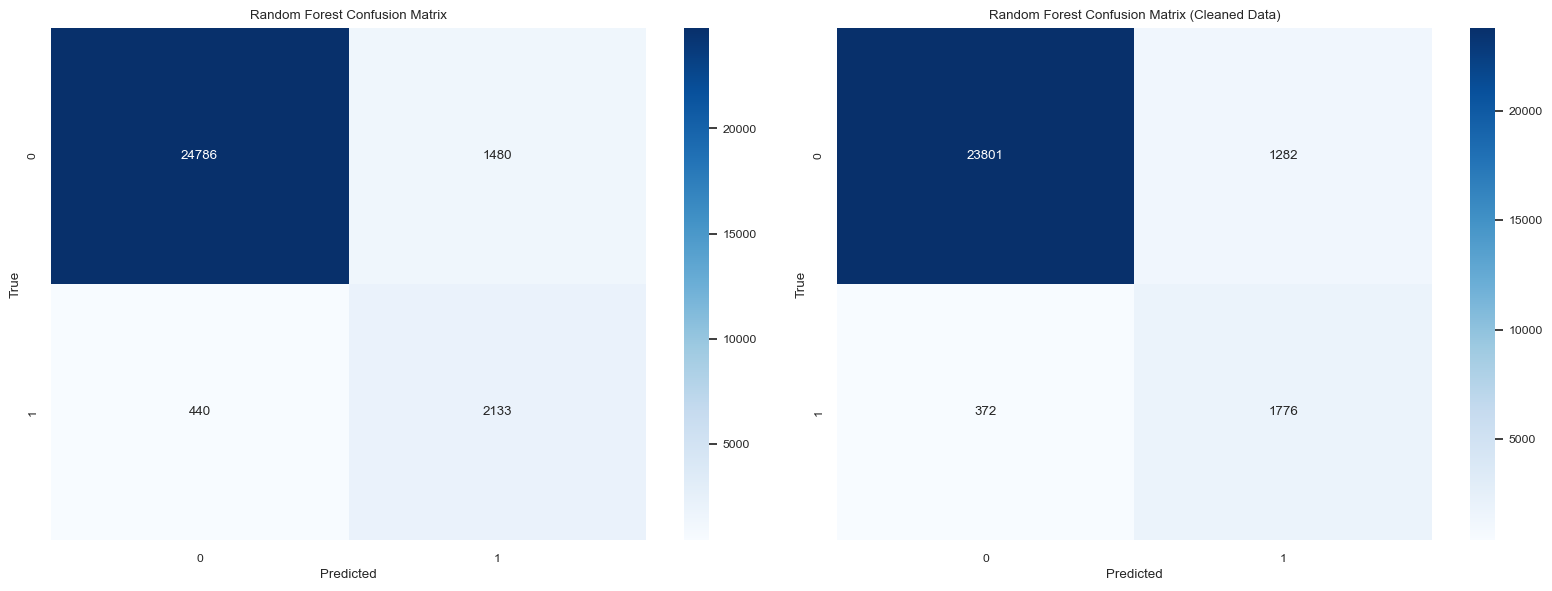

In [40]:

cm = confusion_matrix(y_test, y_pred)
cm_cleaned = confusion_matrix(y_test_cleaned,y_pred_cleaned)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot the second confusion matrix
sns.heatmap(cm_cleaned, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix (Cleaned Data)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Adjust layout
plt.tight_layout()
plt.show()



**Conclusion:**
the classification report showed that outliers did not effect the model so much so for next steps we will not consider the
cleaned data set (the one with no outliers) which may help the model to avoid overfitting

<h3>Random Forest hyperparameter tuning</h3>

In [31]:
param_grid = {
    'classifier__n_estimators': [8, 10, 25], #nb of trees in the forest
    'classifier__max_depth': [None, 4, 7], #max number of levels in each decision tree
    'classifier__min_samples_split': [30, 50, 100], #min number of data points placed in a node before the node is split
    'classifier__min_samples_leaf': [10, 25, 30], #min number of data points allowed in a leaf node
}
scoring = { 'recall': make_scorer(recall_score), 'accuracy': make_scorer(accuracy_score) }

grid_search = GridSearchCV(estimator=random_forest_pipeline,param_grid=param_grid,cv=5,n_jobs=-1,scoring=scoring,refit='recall')

In [32]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_ * 100
results = grid_search.cv_results_
best_index = grid_search.best_index_


In [33]:
print(f"best parameters are:\n {best_params}\n")
print(f"best recall score is {best_score:.2f}%")
print(f"best accuracy score is {results['mean_test_accuracy'][best_index]*100:.2f}%")

best parameters are:
 {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 25, 'classifier__min_samples_split': 30, 'classifier__n_estimators': 10}

best recall score is 91.86%
best accuracy score is 88.58%


classifier report on test data:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     26266
           1       0.44      0.92      0.59      2573

    accuracy                           0.89     28839
   macro avg       0.71      0.90      0.76     28839
weighted avg       0.94      0.89      0.90     28839

--------------------------------------------------
Random Forest: the accuracy of the best estimator on train data is 89.08%
Random Forest: the accuracy of the best estimator on test data is 88.76%
----------
Random Forest: the recall of the best estimator on train data is 92.01%
Random Forest: the recall of the best estimator on test data is 91.57%
----------
Random Forest: the f1 of the best estimator on train data is 59.68%
Random Forest: the f1 of the best estimator on test data is 59.24%
--------------------------------------------------


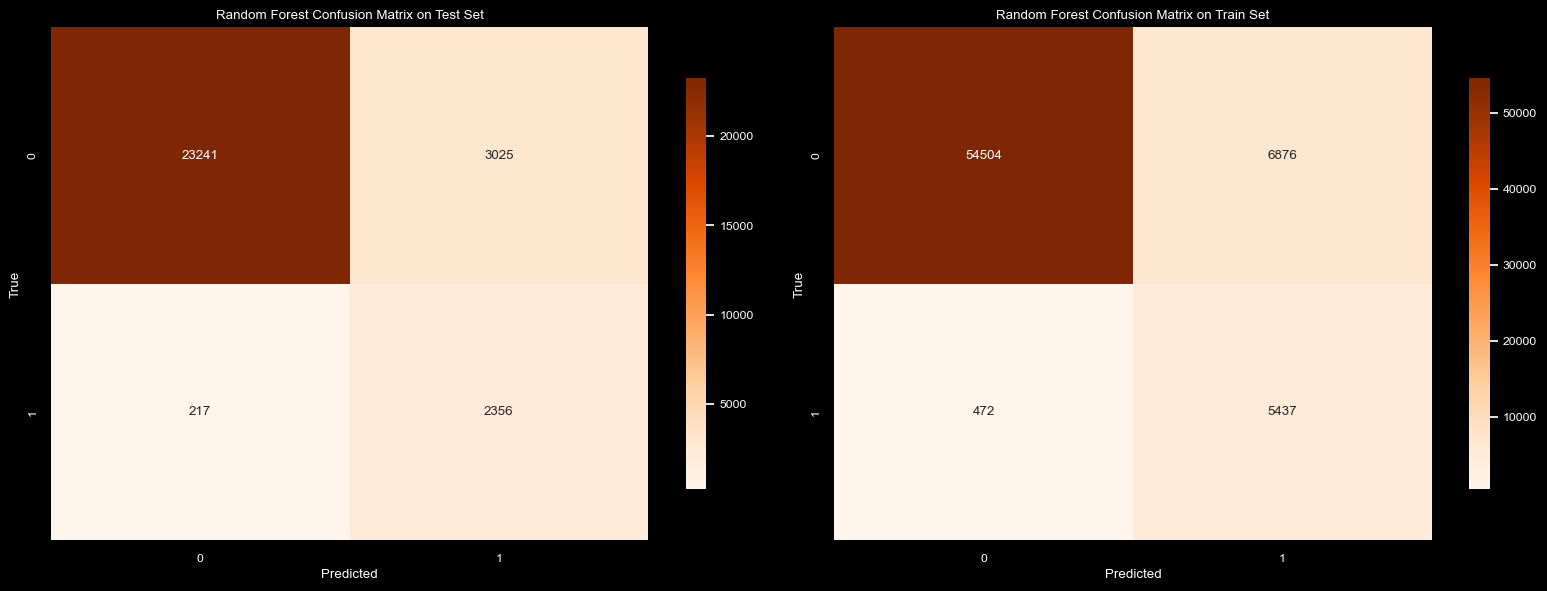

In [34]:
best_rf_model = grid_search.best_estimator_

y_pred_test = best_rf_model.predict(X_test)
y_pred_train = best_rf_model.predict(X_train)

cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train,y_pred_train)

print(f"classifier report on test data:\n {classification_report(y_test, y_pred_test)}")
print("-"*50)
print(f"Random Forest: the accuracy of the best estimator on train data is {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
print(f"Random Forest: the accuracy of the best estimator on test data is {accuracy_score(y_test, y_pred_test) * 100:.2f}%")
print("-"*10)
print(f"Random Forest: the recall of the best estimator on train data is {recall_score(y_train, y_pred_train) * 100:.2f}%")
print(f"Random Forest: the recall of the best estimator on test data is {recall_score(y_test, y_pred_test) * 100:.2f}%")
print("-"*10)
print(f"Random Forest: the f1 of the best estimator on train data is {f1_score(y_train, y_pred_train) * 100:.2f}%")
print(f"Random Forest: the f1 of the best estimator on test data is {f1_score(y_test, y_pred_test) * 100:.2f}%")
print("-"*50)



# Create subplots with a black background
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('black')  # Set figure background to black

# Plot confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title('Random Forest Confusion Matrix on Test Set', color='white')
axes[0].set_xlabel('Predicted', color='white')
axes[0].set_ylabel('True', color='white')
axes[0].tick_params(colors='white')  # Change tick color to white
axes[0].collections[0].colorbar.ax.tick_params(colors='white')  # Change color bar tick color

# Plot confusion matrix for the train set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Random Forest Confusion Matrix on Train Set', color='white')
axes[1].set_xlabel('Predicted', color='white')
axes[1].set_ylabel('True', color='white')
axes[1].tick_params(colors='white')  # Change tick color to white
axes[1].collections[0].colorbar.ax.tick_params(colors='white')  # Change color bar tick color

# Adjust layout
plt.tight_layout()
plt.show()

<h1>AdaBoost Classifier</h1>

In [35]:
ab_classifier = AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=7,min_samples_split=30),n_estimators=10,learning_rate=2.0,algorithm='SAMME.R',random_state=42)

adaboost_pipeline = create_pipeline(ab_classifier)

In [36]:
adaboost_pipeline.fit(X_train, y_train)

y_pred = adaboost_pipeline.predict(X_test)
recall = recall_score(y_test, y_pred) * 100
recall_train_ab = recall_score(y_train, adaboost_pipeline.predict(X_train)) * 100
print(f"adaboost recall on training set {recall_train_ab:.2f}%")
print(f"adaboost recall on testing set: {recall:.2f}%")
print("-"*50)
print(f"adaboost Accuracy on training set: {accuracy_score(y_train, adaboost_pipeline.predict(X_train))*100:.2f}%")
print(f"adaboost Accuracy on testing set: {accuracy_score(y_test, y_pred)*100:.2f}%")


adaboost recall on training set 87.38%
adaboost recall on testing set: 82.12%
--------------------------------------------------
adaboost Accuracy on training set: 95.43%
adaboost Accuracy on testing set: 94.47%


<h3>AdaBoost hyperparameter Tuning</h3>

In [37]:
adaboost_param_grid = {
  'classifier__n_estimators' : [10, 20, 50],
  'classifier__learning_rate' : [0.1, 0.5, 1.0]
}

scoring = { 'recall': make_scorer(recall_score), 'accuracy': make_scorer(accuracy_score) }

adaboost_grid_search = GridSearchCV(estimator=adaboost_pipeline,param_grid=adaboost_param_grid,cv=5,scoring=scoring,refit='recall')
adaboost_grid_search.fit(X_train, y_train)

best_params = adaboost_grid_search.best_params_
adaboost_recall_score = adaboost_grid_search.best_score_ *100
print(f"Best Parameters: {best_params} having recall of {adaboost_recall_score:.2f}%")

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 20} having recall of 92.01%


classifier report on test data:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     26266
           1       0.44      0.92      0.59      2573

    accuracy                           0.89     28839
   macro avg       0.71      0.90      0.76     28839
weighted avg       0.94      0.89      0.90     28839

--------------------------------------------------
AdaBoost: the accuracy of the best estimator on train data is 89.02%
AdaBoost: the accuracy of the best estimator on test data is 88.69%
----------
AdaBoost: the recall of the best estimator on train data is 92.76%
AdaBoost: the recall of the best estimator on test data is 92.27%
----------
AdaBoost: the f1 of the best estimator on train data is 59.74%
AdaBoost: the f1 of the best estimator on test data is 59.27%
--------------------------------------------------


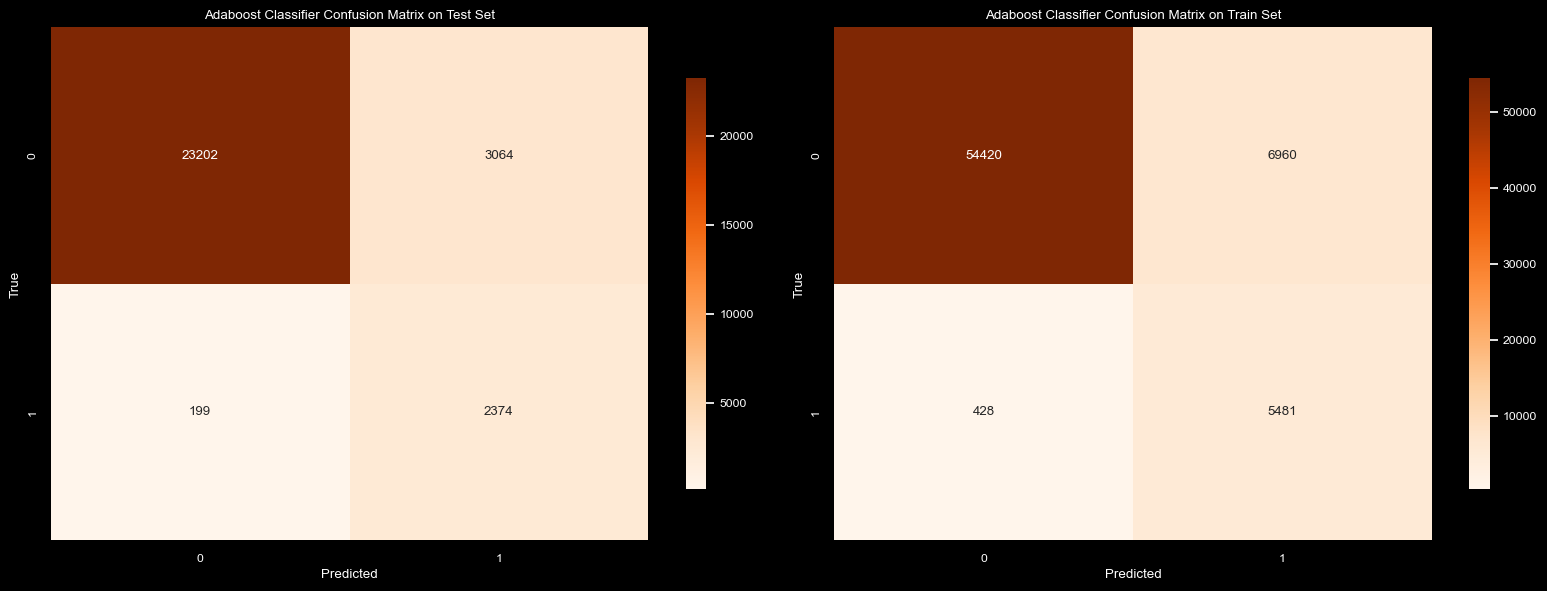

In [39]:
best_ab_model = adaboost_grid_search.best_estimator_

y_pred_test = best_ab_model.predict(X_test)
y_pred_train = best_ab_model.predict(X_train)

cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train,y_pred_train)

print(f"classifier report on test data:\n {classification_report(y_test, y_pred_test)}")
print("-"*50)
print(f"AdaBoost: the accuracy of the best estimator on train data is {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
print(f"AdaBoost: the accuracy of the best estimator on test data is {accuracy_score(y_test, y_pred_test) * 100:.2f}%")
print("-"*10)
print(f"AdaBoost: the recall of the best estimator on train data is {recall_score(y_train, y_pred_train) * 100:.2f}%")
print(f"AdaBoost: the recall of the best estimator on test data is {recall_score(y_test, y_pred_test) * 100:.2f}%")
print("-"*10)
print(f"AdaBoost: the f1 of the best estimator on train data is {f1_score(y_train, y_pred_train) * 100:.2f}%")
print(f"AdaBoost: the f1 of the best estimator on test data is {f1_score(y_test, y_pred_test) * 100:.2f}%")
print("-"*50)


# Create subplots with a black background
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('black')  # Set figure background to black

# Plot confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title('Adaboost Classifier Confusion Matrix on Test Set', color='white')
axes[0].set_xlabel('Predicted', color='white')
axes[0].set_ylabel('True', color='white')
axes[0].tick_params(colors='white')  # Change tick color to white
axes[0].collections[0].colorbar.ax.tick_params(colors='white')  # Change color bar tick color

# Plot confusion matrix for the train set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Adaboost Classifier Confusion Matrix on Train Set', color='white')
axes[1].set_xlabel('Predicted', color='white')
axes[1].set_ylabel('True', color='white')
axes[1].tick_params(colors='white')  # Change tick color to white
axes[1].collections[0].colorbar.ax.tick_params(colors='white')  # Change color bar tick color

# Adjust layout
plt.tight_layout()
plt.show()

<h1>PYTORCH Neural Network Model</h1>

<h5>processing tensors

In [64]:
data_preprocessing_pipeline = create_pipeline(None)
#normalize and encode
X_train_preprocessed = data_preprocessing_pipeline.named_steps['preprocessor'].fit_transform(X_train)
X_train_resampled, y_train_resampled = data_preprocessing_pipeline.named_steps['resampler'].fit_resample(X_train_preprocessed, y_train)

X_test_preprocessed = data_preprocessing_pipeline.named_steps['preprocessor'].transform(X_test)

In [65]:
X_train_tensor = torch.tensor(X_train_resampled).float()
y_train_tensor = torch.tensor(y_train_resampled).float().unsqueeze(1)

X_test_tensor = torch.tensor(X_test_preprocessed).float()
y_test_tensor = torch.tensor(np.array(y_test)).float().unsqueeze(1)

In [66]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([112791, 8]),
 torch.Size([112791, 1]),
 torch.Size([28839, 8]),
 torch.Size([28839, 1]))

In [67]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)
X_train_tensor.shape,y_train_tensor.shape,X_val_tensor.shape,y_val_tensor.shape

(torch.Size([90232, 8]),
 torch.Size([90232, 1]),
 torch.Size([22559, 8]),
 torch.Size([22559, 1]))

<h4>training first model</h4>

In [69]:
"""
In sequential:
layer x -> nn.linear(nb of inputs to each neuron(if it is first layer then here is nb of features), nb of neurons in layer),
		   activation fn for neurons in layer x
layer x+1 ->nn.linear(nb of neurons in prev layer(nb of weights entering each neuron in layer x+1), nb of neurons in current layer),
		   activation fn for neurons in layer x+1

"""
model = nn.Sequential(
    nn.Linear(8, 4),  # Input layer(8) to first hidden layer(4 neurons)
    nn.ReLU(),  # ReLU activation for first hidden layer (ReLu(w1*x1+..+w8*x8+b))
    nn.Linear(4,8),  # First hidden layer to second hidden layern
    nn.ReLU(),
    nn.Linear(8,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16, 1),  # Third hidden layer to output layer
    nn.Sigmoid(),  # Sigmoid activation for the output layer
)

model

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=1, bias=True)
  (9): Sigmoid()
)

In [70]:
loss_function = nn.BCELoss() # Binary Cross-Entropy
adam_optimizer = optim.Adam(model.parameters(), lr=0.1) # Adam optimizer

In [71]:

# Training loop with progress bar
model.train()
epochs = 30
patience = 5  # Number of epochs to wait before stopping
min_delta = 1e-3  # Minimum change in loss to qualify as improvement
best_loss = float('inf')  # Initialize best loss to infinity
early_stop_counter = 0  # Counter for early stopping
adam_optimizer.zero_grad()

train_loader = torch.utils.data.DataLoader(
       		 dataset=list(zip(X_train_tensor, y_train_tensor)),
        	 batch_size=32,
        	 shuffle=True,
    )

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for data, y_actual in train_loader:

        # Zero the gradients
        adam_optimizer.zero_grad()

        # Forward pass
        y_pred = model(data)

        # Compute loss
        loss = loss_function(y_pred, y_actual)

        # Backward pass
        loss.backward()

        # Update weights
        adam_optimizer.step()
        # Update progress bar with current loss


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


In [73]:
# TESTING MODEL ON TEST SET
# Set the model to evaluation mode
model.eval()
# Initialize variables for tracking metrics
y_true_list = []
y_pred_list = []
# Turn off gradients for testing
with torch.no_grad():
        # Forward pass to get predictions
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)
        # Apply threshold for binary classification
        y_pred_test_class = (y_pred_test > 0.5).float()
        y_pred_train_class = (y_pred_train > 0.5).float()
        
        acc_test = accuracy_score(y_test_tensor.numpy(), y_pred_test_class.numpy()) * 100
        recall_test = recall_score(y_test_tensor.numpy(), y_pred_test_class.numpy()) * 100
        
        acc_train = accuracy_score(y_train_tensor.numpy(), y_pred_train_class.numpy()) * 100
        recall_train = recall_score(y_train_tensor.numpy(), y_pred_train_class.numpy()) * 100


conf_matrix_test = confusion_matrix(y_test, y_pred_test_class)


# Print metrics and confusion matrix

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")
print("*"*50)
print(f"Train Recall: {recall_train:.4f}")
print(f"Test Recall: {recall_test:.4f}")

print("Test Set Confusion Matrix:")
print(conf_matrix_test)

Train Accuracy: 51.4019
Test Accuracy: 8.9219
**************************************************
Train Recall: 100.0000
Test Recall: 100.0000
Test Set Confusion Matrix:
[[    0 26266]
 [    0  2573]]


It is obvious that the model is not working well!!

<h1>Hyper Parameter Tuning for NN</h1>

In [124]:
def create_model(input_dim, hidden_1, hidden_2, hidden_3, dropout_rate, output=1):
    if hidden_3 > 0:
        model = nn.Sequential(
            nn.Linear(input_dim, hidden_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_2, hidden_3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_3, output),
            nn.Sigmoid(),
        )
    else:
        model = nn.Sequential(
            nn.Linear(input_dim, hidden_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_2, output),
            nn.Sigmoid(),
        )
    return model

In [66]:
# Define hyperparameters
param_grid = {
    "hidden_1": [8,16],
    "hidden_2": [8,16],
    "hidden_3":[4,8,16],
    "dropout_rate": [0.25, 0.5],
    "learning_rate": [0.001, 0.01],
    "batch_size": [512,1024,2048],
    "weight_decay":[0,1e-4,1e-3]
}


In [ ]:
grid_combinations = list(product(*param_grid.values()))
best_model = None
best_train_acc = 0
best_param = dict()
min_delta = 1e-3
patience = 5
epochs = 30
best_train_recall=0

for comb_nb,combination in enumerate(grid_combinations):
    params = dict(zip(param_grid.keys(), combination))
    print("")
    print("-"*100)
    print("")
    print(f"combination {comb_nb} / {len(grid_combinations)}")
    print(f"training with {params}")
    model = create_model(
        input_dim=8,
        hidden_1=params["hidden_1"],
        hidden_2=params["hidden_2"],
        hidden_3=params["hidden_3"],
        dropout_rate=params["dropout_rate"],
    )
    opt = optim.Adam(model.parameters(), lr=params["learning_rate"],weight_decay=params["weight_decay"])
    loss_function = nn.BCELoss()

    train_loader = torch.utils.data.DataLoader(
        dataset=list(zip(X_train_tensor, y_train_tensor)),
        batch_size=params["batch_size"],
        shuffle=False,
    )
    model.train()
    best_loss = float("inf")
    for epoch in range(epochs):
        epoch_loss = 0.0
        print(f"Epoch {epoch+1}/{epochs}")
        for data, labels in train_loader:
            opt.zero_grad()
            y_pred = model(data)
            loss = loss_function(y_pred, labels)
            loss.backward()
            opt.step()
        
        if epoch_loss < best_loss - min_delta:
            best_loss = epoch_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                break
    
    model.eval()
    with torch.no_grad():
        
        y_train_pred = model(X_train_tensor)
        y_val_pred = model(X_val_tensor)

        train_pred = (y_train_pred > 0.5).float()
        val_pred = (y_val_pred > 0.5).float()

        train_acc = accuracy_score(y_train_tensor.numpy(), train_pred.numpy()) * 100
        train_recall = recall_score(y_train_tensor.numpy(), train_pred.numpy()) * 100

        val_acc = accuracy_score(y_val_tensor.numpy(), val_pred.numpy()) * 100
        val_recall = recall_score(y_val_tensor.numpy(), val_pred.numpy()) * 100 
        
    results = (
        f"train Accuracy: {train_acc:.2f}\n"
        f"val Accuracy: {val_acc:.2f}\n"
        f"{'*' * 50}\n"
        f"train Recall: {train_recall:.2f}\n"
        f"val Recall: {val_recall:.2f}\n"
    )
    print(results)
    acc_diff = abs(val_acc - train_acc)<6
    recall_diff = abs(val_recall - train_recall)<4
    if train_recall > best_train_recall and train_acc > best_train_acc and recall_diff and acc_diff:
        best_model = model
        
        best_train_recall = train_recall
        best_train_acc = train_acc
        
        best_val_recall = val_recall
        best_val_acc = val_acc 
        
        best_params = params

        update = (
            f"best train recall updated to {best_train_recall:.2f}%\n"
            f"best params for now are {best_params}\n"
        )
        print(update)

final_results = (
    f"best model is {best_model}\n"
    f"best train recall is {best_train_recall:.2f}&\n best val recall is {val_recall:.2f}%\n"
    f"best train acc is {best_train_acc:.2f}%\n best val acc is {val_acc:.2f}%"
)
print(final_results)


In [76]:
print({'hidden_1': 16, 'hidden_2': 8, 'hidden_3': 16, 'dropout_rate': 0.25, 'learning_rate': 0.01, 'batch_size': 1024, 'weight_decay': 0.0001})
print("-"*25)
print(f"best training recall: {best_train_recall:.2f}%")
print(f"best training accuracy: {best_train_acc:.2f}%")
print("-"*25)
print(best_model)

{'hidden_1': 16, 'hidden_2': 8, 'hidden_3': 16, 'dropout_rate': 0.25, 'learning_rate': 0.01, 'batch_size': 1024, 'weight_decay': 0.0001}
-------------------------
best training recall: 97.11%
best training accuracy: 94.94%
-------------------------
Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=8, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.25, inplace=False)
  (9): Linear(in_features=16, out_features=1, bias=True)
  (10): Sigmoid()
)


NEURAL NETWORK RECALL:

 (training set): 97.11%
 (testing set): 94.64%
--------------------------------------------------
NEURAL NETWORK ACCURACY:

 (training set): 94.94%
 (testing set): 86.49%
--------------------------------------------------
NEURAL NETWORK F1 SCORE:

 (training set): 95.08%
 (testing set): 55.56%
--------------------------------------------------


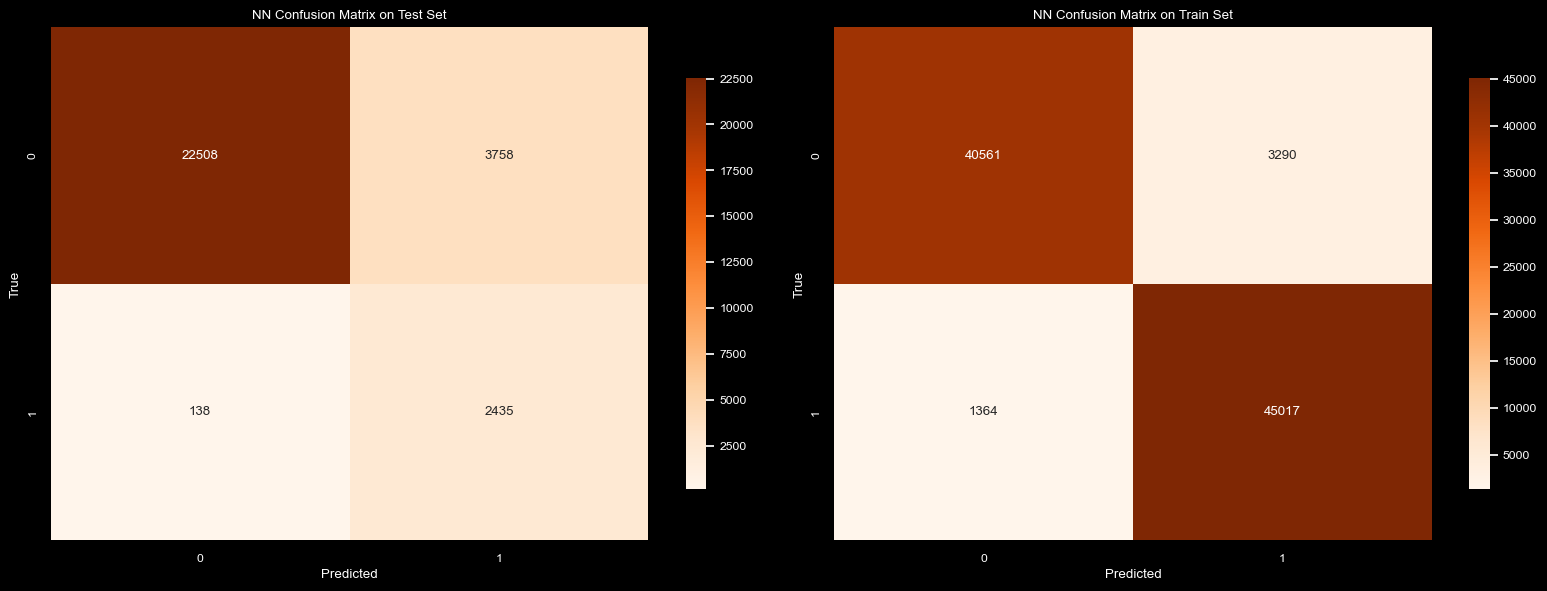

In [115]:
best_model.eval()

with torch.no_grad():
    y_pred_test = best_model(X_test_tensor)
    y_pred_train = best_model(X_train_tensor)
    
    y_pred_test = (y_pred_test > 0.5).float()
    y_pred_train = (y_pred_train > 0.5).float()
    
    nn_test_acc = accuracy_score(y_test_tensor.numpy(),y_pred_test.numpy())*100
    nn_test_recall = recall_score(y_test_tensor.numpy(),y_pred_test.numpy())*100
    
    best_train_f1 = f1_score(y_train_tensor.numpy(),y_pred_train.numpy())*100
    nn_test_f1 = f1_score(y_test_tensor.numpy(),y_pred_test.numpy())*100
    
    nn_test_conf_matrix = confusion_matrix(y_test_tensor.numpy(), y_pred_test.numpy())
    nn_training_conf_matrix = confusion_matrix(y_train_tensor.numpy(),y_pred_train.numpy())

print("NEURAL NETWORK RECALL:\n")
print(f" (training set): {best_train_recall:.2f}%")
print(f" (testing set): {nn_test_recall:.2f}%")
print("-"*50)
print("NEURAL NETWORK ACCURACY:\n")
print(f" (training set): {best_train_acc:.2f}%")
print(f" (testing set): {nn_test_acc:.2f}%")
print("-"*50)
print("NEURAL NETWORK F1 SCORE:\n")
print(f" (training set): {best_train_f1:.2f}%")
print(f" (testing set): {nn_test_f1:.2f}%")
print("-"*50)

# Create subplots with a black background
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('black')  # Set figure background to black

# Plot confusion matrix for the test set
sns.heatmap(nn_test_conf_matrix, annot=True, fmt='d', cmap='Oranges', ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title('NN Confusion Matrix on Test Set', color='white')
axes[0].set_xlabel('Predicted', color='white')
axes[0].set_ylabel('True', color='white')
axes[0].tick_params(colors='white')  # Change tick color to white
axes[0].collections[0].colorbar.ax.tick_params(colors='white')  # Change color bar tick color

# Plot confusion matrix for the train set
sns.heatmap(nn_training_conf_matrix, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('NN Confusion Matrix on Train Set', color='white')
axes[1].set_xlabel('Predicted', color='white')
axes[1].set_ylabel('True', color='white')
axes[1].tick_params(colors='white')  # Change tick color to white
axes[1].collections[0].colorbar.ax.tick_params(colors='white')  # Change color bar tick color

# Adjust layout
plt.tight_layout()
plt.show()